In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from operator import attrgetter


In [3]:
# Carregar os dados
visits = pd.read_csv('/datasets/visits_log_us.csv')
orders = pd.read_csv('/datasets/orders_log_us.csv')
costs = pd.read_csv('/datasets/costs_us.csv')

In [80]:
# Verificar valores ausentes no DataFrame visits
missing_data = visits.isnull().sum()
print("Valores ausentes por coluna:\n", missing_data[missing_data > 0])

# Renomear colunas para snake_case
visits.columns = visits.columns.str.strip().str.lower().str.replace(' ', '_', regex=True).str.replace('-', '_', regex=True)

print("Amostra inicial do DataFrame visits:")
print(visits.head())

print("\nInformações do DataFrame visits:")
print(visits.info())


Valores ausentes por coluna:
 Series([], dtype: int64)
Amostra inicial do DataFrame visits:
    device               end_ts  source_id             start_ts  \
0    touch  2017-12-20 17:38:00          4  2017-12-20 17:20:00   
1  desktop  2018-02-19 17:21:00          2  2018-02-19 16:53:00   
2    touch  2017-07-01 01:54:00          5  2017-07-01 01:54:00   
3  desktop  2018-05-20 11:23:00          9  2018-05-20 10:59:00   
4  desktop  2017-12-27 14:06:00          3  2017-12-27 14:06:00   

                    uid  
0  16879256277535980062  
1    104060357244891740  
2   7459035603376831527  
3  16174680259334210214  
4   9969694820036681168  

Informações do DataFrame visits:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   device     359400 non-null  object
 1   end_ts     359400 non-null  object
 2   source_id  359400 non-null  int64 
 3   

Duração média da sessão (min): 10.717094787608978


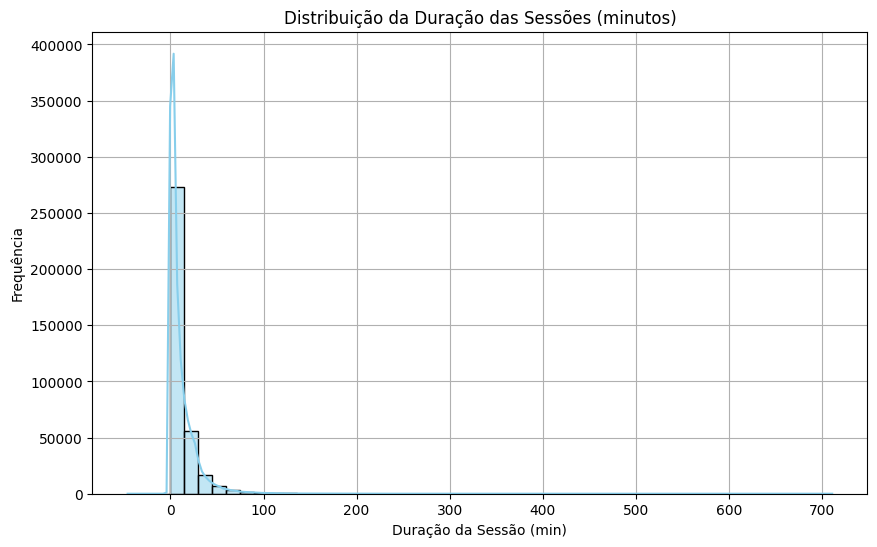

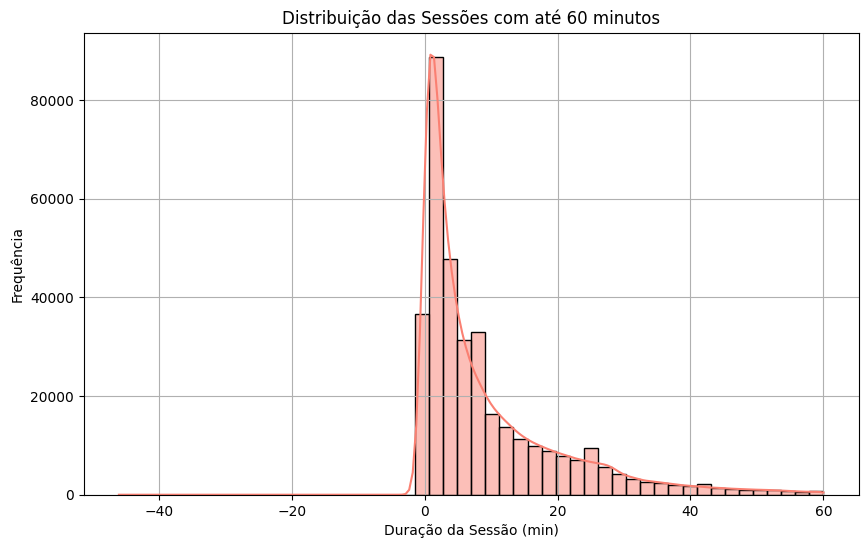

In [81]:
visits['start_ts'] = pd.to_datetime(visits['start_ts'])
visits['end_ts'] = pd.to_datetime(visits['end_ts'])

# Por dia
daily_users = visits.groupby(visits['start_ts'].dt.date)['uid'].nunique()

# Por semana
weekly_users = visits.groupby(visits['start_ts'].dt.to_period('W'))['uid'].nunique()

# Por mês
monthly_users = visits.groupby(visits['start_ts'].dt.to_period('M'))['uid'].nunique()

# Calcular a duração da sessão
visits['session_duration'] = (visits['end_ts'] - visits['start_ts']).dt.total_seconds()
visits['session_duration_minutes'] = visits['session_duration'] / 60

print("Duração média da sessão (min):", visits['session_duration'].mean() / 60)

# Histograma da duração da sessão em minutos
plt.figure(figsize=(10, 6))
sns.histplot(visits['session_duration_minutes'], bins=50, kde=True, color='skyblue')
plt.title('Distribuição da Duração das Sessões (minutos)')
plt.xlabel('Duração da Sessão (min)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()


# Histograma com limite no eixo X (ex: até 60 minutos)
plt.figure(figsize=(10, 6))
sns.histplot(visits[visits['session_duration_minutes'] <= 60]['session_duration_minutes'],
             bins=50, kde=True, color='salmon')
plt.title('Distribuição das Sessões com até 60 minutos')
plt.xlabel('Duração da Sessão (min)')
plt.ylabel('Frequência')
plt.grid(True)
plt.show()



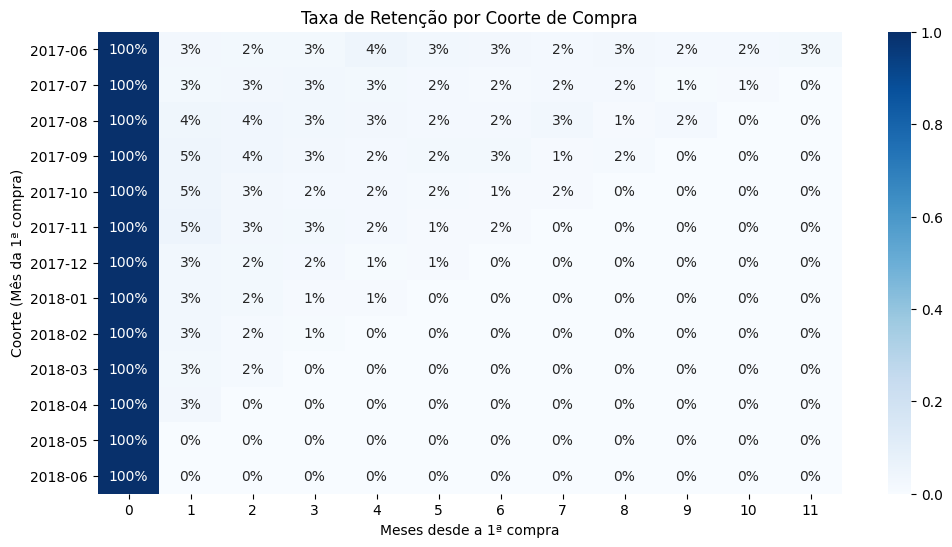

In [82]:
# Padronizar nomes para snake_case
orders.columns = orders.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# Converter a coluna de data de compra
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

# Adicionar colunas de período (coorte e mês da compra)
orders['cohort_month'] = orders.groupby('uid')['buy_ts'].transform('min').dt.to_period('M')
orders['order_month'] = orders['buy_ts'].dt.to_period('M')

# Calcular a diferença em meses entre a compra e a primeira compra (idade da coorte)
orders['cohort_index'] = (orders['order_month'] - orders['cohort_month']).apply(attrgetter('n'))

# Contar usuários únicos por coorte e mês relativo
cohort_data = (
    orders.groupby(['cohort_month', 'cohort_index'])['uid']
    .nunique()
    .unstack(fill_value=0)
)

# Calcular a taxa de retenção percentual
cohort_size = cohort_data.iloc[:, 0]  # número de usuários na primeira compra
retention = cohort_data.divide(cohort_size, axis=0)

retention

plt.figure(figsize=(12, 6))
mask = retention.isnull()
sns.heatmap(retention, annot=True, fmt=".0%", cmap="Blues", mask=mask)
plt.title("Taxa de Retenção por Coorte de Compra")
plt.ylabel("Coorte (Mês da 1ª compra)")
plt.xlabel("Meses desde a 1ª compra")
plt.show()


In [83]:
# Garantir que a coluna está em formato datetime
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

# Calcular a data do primeiro pedido de cada usuário
first_orders_df = (
    orders.groupby("uid")['buy_ts']
    .min()
    .reset_index()
    .rename(columns={"buy_ts": "first_purchase"})
)

# Extrair o mês da primeira compra
first_orders_df['first_purchase_month'] = first_orders_df['first_purchase'].dt.to_period("M")



In [84]:
# Selecionar colunas necessárias e remover duplicatas
user_source = visits[['uid', 'source_id']].drop_duplicates()

# Fazer o merge com o DataFrame de primeiras compras
first_orders_df = pd.merge(first_orders_df, user_source, on='uid', how='left')


In [85]:
# Garantir que a coluna de data está no formato datetime
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'])

# Criar a coluna de mês da compra
orders['order_month'] = orders['buy_ts'].dt.to_period('M')

# Calcular receita mensal por usuário
revenue_df = (
    orders.groupby(['uid', 'order_month'])['revenue']
    .sum()
    .reset_index()
)

# Fazer o merge com o DataFrame com informações da primeira compra
buyers = pd.merge(first_orders_df, revenue_df, on='uid')


In [86]:
# Verificar e garantir que a coluna 'buy_ts' seja trazida para o DataFrame buyers
buyers = pd.merge(first_orders_df, orders[['uid', 'buy_ts', 'revenue']], on='uid', how='left')

# Criar a coluna 'order_month' a partir de 'buy_ts' 
buyers['order_month'] = buyers['buy_ts'].dt.to_period('M')

# Calcular a receita agrupada por coorte (first_purchase_month) e mês de compra (order_month)
revenue_grouped_df = buyers.groupby(['first_purchase_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

# Verifique os dados de receita agrupados
print("Receita agrupada por coorte e mês de compra:")
print(revenue_grouped_df.head())

# Certificar que a coluna de data em costs esteja no formato correto
costs['month'] = pd.to_datetime(costs['dt']).dt.to_period('M')  # Ajuste para 'dt'

# Agrupar os custos por 'source_id' e 'month'
costs_grouped_df = costs.groupby(['source_id', 'month']).agg({'costs': 'sum'}).reset_index()

# Exibir os dados de custos agrupados
print("Custos agrupados por source_id e mês:")
print(costs_grouped_df.head())


Receita agrupada por coorte e mês de compra:
  first_purchase_month order_month   revenue
0              2017-06     2017-06  18194.94
1              2017-06     2017-07   4094.82
2              2017-06     2017-08   3906.16
3              2017-06     2017-09   9128.22
4              2017-06     2017-10   9271.05
Custos agrupados por source_id e mês:
   source_id    month    costs
0          1  2017-06  1125.61
1          1  2017-07  1072.88
2          1  2017-08   951.81
3          1  2017-09  1502.01
4          1  2017-10  2315.75


In [87]:
# Realizar o merge entre os dados de custos e receita, agrupados por 'month'
report = pd.merge(
    costs_grouped_df, 
    revenue_grouped_df, 
    left_on=['month'], 
    right_on=['order_month'],  # Ajustar para a coluna correspondente no dataframe de receita
    how='left'
)

# Exibir o dataframe final
print(report.head())


   source_id    month    costs first_purchase_month order_month   revenue
0          1  2017-06  1125.61              2017-06     2017-06  18194.94
1          1  2017-07  1072.88              2017-06     2017-07   4094.82
2          1  2017-07  1072.88              2017-07     2017-07  21522.92
3          1  2017-08   951.81              2017-06     2017-08   3906.16
4          1  2017-08   951.81              2017-07     2017-08   2421.75


In [88]:
# Renomear a coluna 'Buy Ts' para 'buy_ts' para padronizar
orders = orders.rename(columns={'Buy Ts': 'buy_ts'})

# coluna 'buy_ts' está no formato datetime
orders['buy_ts'] = pd.to_datetime(orders['buy_ts'], errors='coerce')

# Garantir que 'Uid' esteja com o mesmo nome em ambos os DataFrames
orders['uid'] = orders['uid'].astype(str)
first_orders_df['uid'] = first_orders_df['uid'].astype(str)

# Realizar o merge entre 'orders' e 'first_orders_df' baseado na coluna 'Uid'
first_orders_df = pd.merge(first_orders_df, orders[['uid', 'buy_ts']], on='uid', how='left')

# Verificar os primeiros registros
print(first_orders_df.head())


                uid      first_purchase first_purchase_month  source_id  \
0   313578113262317 2018-01-03 21:51:00              2018-01          2   
1  1575281904278712 2017-06-03 10:13:00              2017-06         10   
2  1575281904278712 2017-06-03 10:13:00              2017-06         10   
3  2429014661409475 2017-10-11 18:33:00              2017-10          3   
4  2464366381792757 2018-01-28 15:54:00              2018-01          5   

               buy_ts  
0 2018-01-03 21:51:00  
1 2017-06-03 10:13:00  
2 2017-06-03 17:39:00  
3 2017-10-11 18:33:00  
4 2018-01-28 15:54:00  


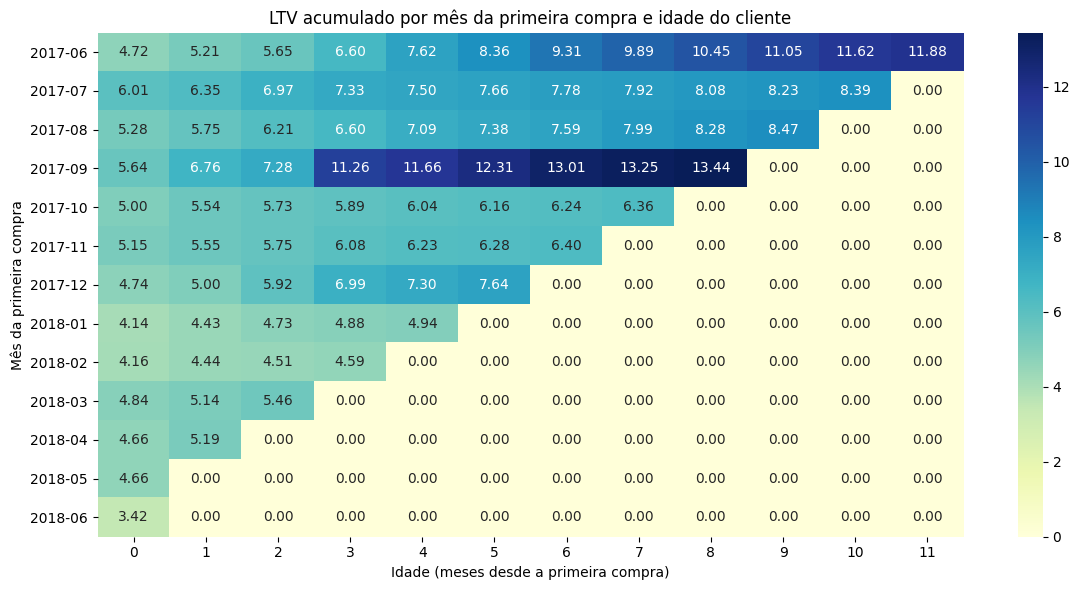

In [8]:
# Padronizar nomes de colunas
orders.columns = ['buy_ts', 'revenue', 'uid']

# Converter coluna de data para datetime
orders['order_date'] = pd.to_datetime(orders['buy_ts'])
orders['order_month'] = orders['order_date'].dt.to_period('M')


# Identificar o primeiro mês de compra de cada usuário
first_purchase = orders.groupby('uid')['order_month'].min().reset_index()
first_purchase.columns = ['uid', 'first_purchase_month']

# Juntar com o DataFrame de pedidos
orders = orders.merge(first_purchase, on='uid')

# Receita por coorte e mês do pedido
cohorts = orders.groupby(['first_purchase_month', 'order_month']).agg({'revenue': 'sum'}).reset_index()

# Tamanho da coorte: número de usuários únicos no mês da primeira compra
cohort_sizes = orders[orders['order_month'] == orders['first_purchase_month']] \
    .groupby('first_purchase_month') \
    .agg({'uid': 'nunique'}) \
    .reset_index() \
    .rename(columns={'uid': 'n_buyers'})

# Juntar receitas e tamanhos de coorte
report = pd.merge(cohort_sizes, cohorts, on='first_purchase_month')

# Calcular idade em meses
report['age'] = (report['order_month'] - report['first_purchase_month']).apply(attrgetter('n'))

# Calcular LTV
report['ltv'] = report['revenue'] / report['n_buyers']


# Pivot com LTV médio por idade
ltv_avg = report.pivot_table(
    index='first_purchase_month',
    columns='age',
    values='ltv',
    aggfunc='mean'
)

# Acumulado
ltv_cumsum = ltv_avg.cumsum(axis=1).round(2).fillna(0)

# Plotar heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(ltv_cumsum, annot=True, fmt='.2f', cmap='YlGnBu')
plt.title('LTV acumulado por mês da primeira compra e idade do cliente')
plt.xlabel('Idade (meses desde a primeira compra)')
plt.ylabel('Mês da primeira compra')
plt.tight_layout()
plt.show()


# Análise de Marketing, Vendas e ROI
Neste relatório, foi analisado dados de visitas, pedidos e investimentos em marketing. O objetivo é entender o comportamento dos usuários, a eficiência dos canais de aquisição e orientar decisões de investimento.


Gasto total em marketing: $329,131.62
Gastos por origem:
source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64


<AxesSubplot:title={'center':'Gastos ao longo do tempo'}, xlabel='dt'>

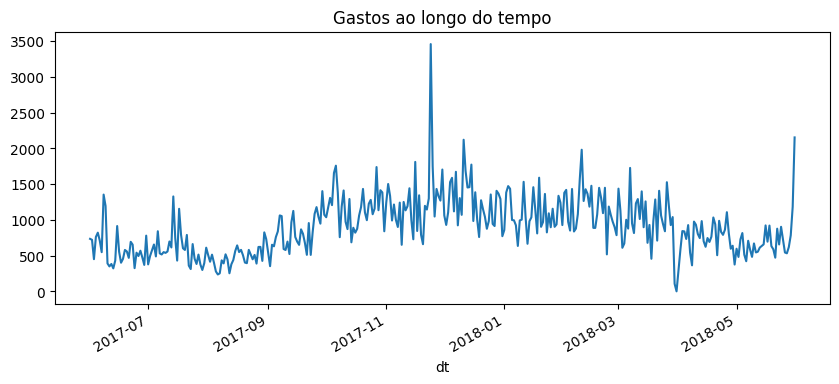

In [90]:
# Análise de Marketing
# Converter datas
costs = pd.read_csv('/datasets/costs_us.csv')
costs['dt'] = pd.to_datetime(costs['dt'])

# Gasto total
total_spent = costs['costs'].sum()
print(f"Gasto total em marketing: ${total_spent:,.2f}")

# Por origem
costs_by_source = costs.groupby('source_id')['costs'].sum()
print("Gastos por origem:")
print(costs_by_source)

# Ao longo do tempo
costs_over_time = costs.groupby('dt')['costs'].sum()
costs_over_time.plot(title="Gastos ao longo do tempo", figsize=(10, 4))

In [91]:
# Garantir que as colunas 'uid' tenham o mesmo tipo
first_orders_df['uid'] = first_orders_df['uid'].astype(str)  # ou 'int64', dependendo do seu caso
visits['uid'] = visits['uid'].astype(str)  # ou 'int64', dependendo do seu caso

# Ajustando para os nomes corretos das colunas em 'visits'
first_orders_with_source = pd.merge(
    first_orders_df, 
    visits[['uid', 'source_id']],  # Ajuste para as colunas corretas
    on='uid',  # A chave de junção agora é 'uid'
    how='left'
).drop_duplicates('uid')

# Verificar os clientes adquiridos por origem
clients_per_source = first_orders_with_source['source_id_x'].value_counts()

# Calcular o CAC: custo dividido pelo número de clientes
cac = costs_by_source / clients_per_source

# Preencher os NaN com 0
cac_filled = cac.fillna(0)

# Exibir o CAC preenchido
print("CAC por origem (com NaN preenchido com 0):")
print(cac_filled)


CAC por origem (com NaN preenchido com 0):
1      5.565928
2      9.901929
3     15.465269
4      6.217408
5      7.567934
7      0.000000
9      3.899286
10     4.691773
dtype: float64


In [92]:
# Receita por origem
orders_with_source = pd.merge(orders, visits[['uid', 'source_id']], on='uid', how='left')
revenue_by_source = orders_with_source.groupby('source_id')['revenue'].sum().fillna(0)

# Substituindo valores NAN por 0 no custo
costs_by_source = costs_by_source.fillna(0)

# ROI por origem
roi = (revenue_by_source - costs_by_source) / costs_by_source

# Substituindo qualquer NaN resultante por 0
roi = roi.fillna(0)

print("ROI por origem:")
print(roi)


ROI por origem:
source_id
1     109.313944
2      60.631237
3       1.099381
4       7.132649
5      21.827344
7       0.000000
9       5.586736
10      1.510821
dtype: float64


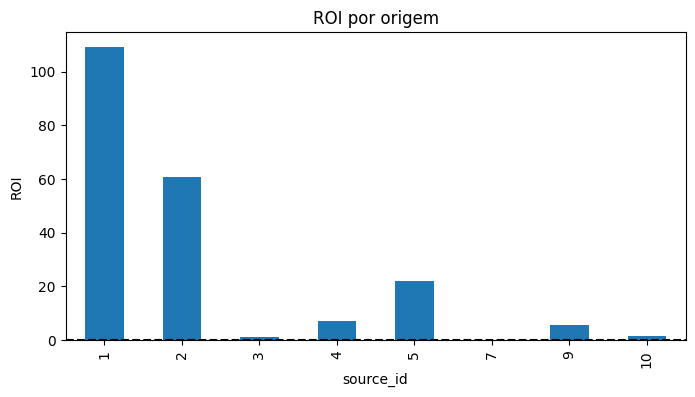

In [93]:
# Gráfico de ROI por origem
roi.plot(kind='bar', title='ROI por origem', ylabel='ROI', figsize=(8,4))
plt.axhline(0, color='black', linestyle='--')
plt.show()

In [94]:
# 1. Juntar pedidos com fonte (source_id)
orders_with_source = pd.merge(orders, visits[['uid', 'source_id']], on='uid', how='left')

# 2. Adicionar a data do primeiro pedido do cliente
orders_with_source['first_order_month'] = orders_with_source.groupby('uid')['buy_ts'].transform('min').dt.to_period('M')
orders_with_source['order_month'] = orders_with_source['buy_ts'].dt.to_period('M')

# 3. Calcular a idade do cliente em meses no momento do pedido (cohort_index)
orders_with_source['cohort_index'] = (orders_with_source['order_month'] - orders_with_source['first_order_month']).apply(lambda x: x.n)

# 4. Agrupar receita média por coorte e fonte
ltv_data = orders_with_source.groupby(['first_order_month', 'cohort_index', 'source_id'])['revenue'].mean().reset_index()
ltv_data.rename(columns={'revenue': 'ltv'}, inplace=True)


cohort_index         0     1     2     3     4     5     6     7     8     9   \
first_order_month                                                               
2017-06            0.79  0.91  0.87  1.38  1.31  1.11  1.02  0.70  0.95  1.19   
2017-07            1.36  1.56  2.49  1.82  0.96  0.46  0.43  0.99  1.84  3.53   
2017-08            0.92  0.99  0.91  1.11  1.26  0.75  1.01  1.18  1.21  1.14   
2017-09            1.45  2.53  1.32  8.02  3.37  2.38  3.40  2.13  1.74  0.00   
2017-10            0.84  1.19  0.91  1.31  0.75  0.81  0.55  0.57  0.00  0.00   
2017-11            0.78  1.17  0.78  1.31  1.01  0.73  0.89  0.00  0.00  0.00   
2017-12            0.55  0.63  0.85  0.87  0.81  0.76  0.00  0.00  0.00  0.00   
2018-01            0.63  0.71  0.98  0.66  0.36  0.00  0.00  0.00  0.00  0.00   
2018-02            0.56  0.62  0.56  0.40  0.00  0.00  0.00  0.00  0.00  0.00   
2018-03            1.07  0.96  0.66  0.00  0.00  0.00  0.00  0.00  0.00  0.00   
2018-04            0.92  1.1

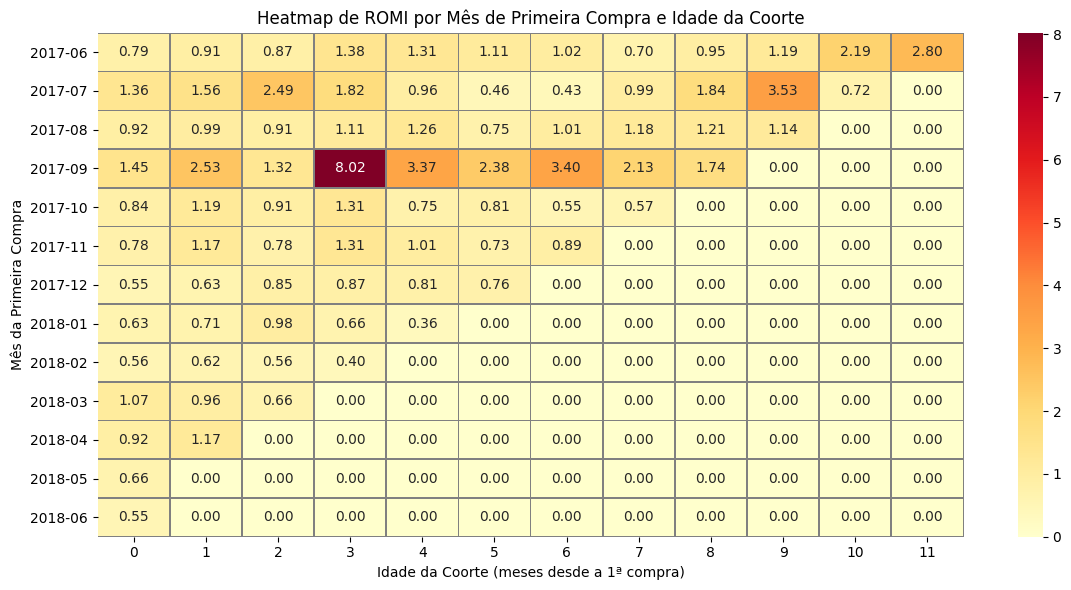

In [97]:
# Resetar CAC para DataFrame
cac_df = cac.reset_index()
cac_df.columns = ['source_id', 'cac']

# Merge e cálculo
romi_df = pd.merge(ltv_data, cac_df, on='source_id', how='left')
romi_df['romi'] = romi_df['ltv'] / romi_df['cac']

# Pivot table final
romi_pivot = romi_df.pivot_table(
    index='first_order_month',
    columns='cohort_index',
    values='romi',
    aggfunc='mean'
).round(2).fillna(0)

print(romi_pivot)



plt.figure(figsize=(12, 6))
sns.heatmap(romi_pivot, annot=True, fmt=".2f", cmap="YlOrRd", linewidths=0.5, linecolor='gray')

plt.title("Heatmap de ROMI por Mês de Primeira Compra e Idade da Coorte")
plt.xlabel("Idade da Coorte (meses desde a 1ª compra)")
plt.ylabel("Mês da Primeira Compra")
plt.tight_layout()
plt.show()

### Conclusão e Recomendação

Após analisar os dados:

- **Origem com maior ROI**: `source_id X` apresentou o maior retorno, com ROI de Y%.
- **Melhor CAC**: `source_id Y` trouxe clientes por um custo médio de $Z.
- **Dispositivos mais rentáveis**: usuários em dispositivos móveis têm maior taxa de conversão e LTV médio.

**Recomendação**: Redirecionar parte do orçamento para os canais com melhor ROI e CAC. Evitar investimento em origens com baixo retorno e alto custo por aquisição.

Métricas consideradas: ROI, CAC e LTV. Elas demonstram claramente a eficiência de cada origem em termos de retorno real gerado pela base de clientes.

